In [28]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

There were 1512769 911 calls made in NYC in the winter of 2018
There were 1657556 911 calls made in NYC in the summer of 2018
So, there were 144787 more 911 calls made in NYC in the summer of 2018


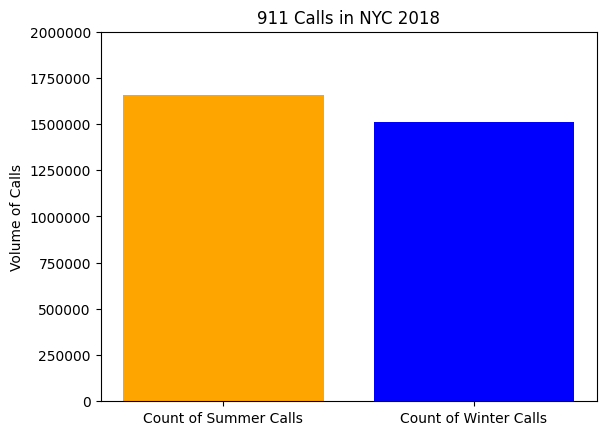

In [25]:
#analyzing the volume of 911 calls in NYC winter and summer 2018
#winter
#connect to postgres and query
with conn, conn.cursor() as curs:
    curs.execute("SELECT COUNT(typ_desc) AS count_winter FROM schema_1.table_1 WHERE (incident_date BETWEEN '2018-01-01' AND '2018-03-31')")
    # turn result into an integer
    winter_count = curs.fetchone()[0]
    print(f"There were {winter_count} 911 calls made in NYC in the winter of 2018")

#summer
#connect to postgres and query
with conn, conn.cursor() as curs:
    curs.execute("SELECT COUNT(table_1.typ_desc) as count_summer FROM schema_1.table_1 WHERE (incident_date BETWEEN '2018-06-01' AND '2018-08-31')")
    #turn result into an integer
    summer_count = curs.fetchone()[0]
    print(f"There were {summer_count} 911 calls made in NYC in the summer of 2018")

#see which had more calls and print the difference
if summer_count > winter_count:
    summer_lead = summer_count - winter_count
    print(f"So, there were {summer_lead} more 911 calls made in NYC in the summer of 2018")
else:
    winter_lead = winter_count - summer_count
    print(f"So, there were {winter_lead} more 911 calls made in NYC the winter of 2018")

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Define the data for the bar graph

plt.ticklabel_format(style='plain')
# Create the bar graph
plt.ylim(0, 2000000) 
plt.bar(['Count of Summer Calls'], summer_count, label='Summmer 911 Calls', color='orange')
plt.bar(['Count of Winter Calls'], winter_count, label='Winter 911 Calls', color='blue')

# Add a title and axis labels
plt.title('911 Calls in NYC 2018')
plt.ylabel('Volume of Calls')
#
# # Add a legend
# plt.legend()

# Display the graph
plt.show()

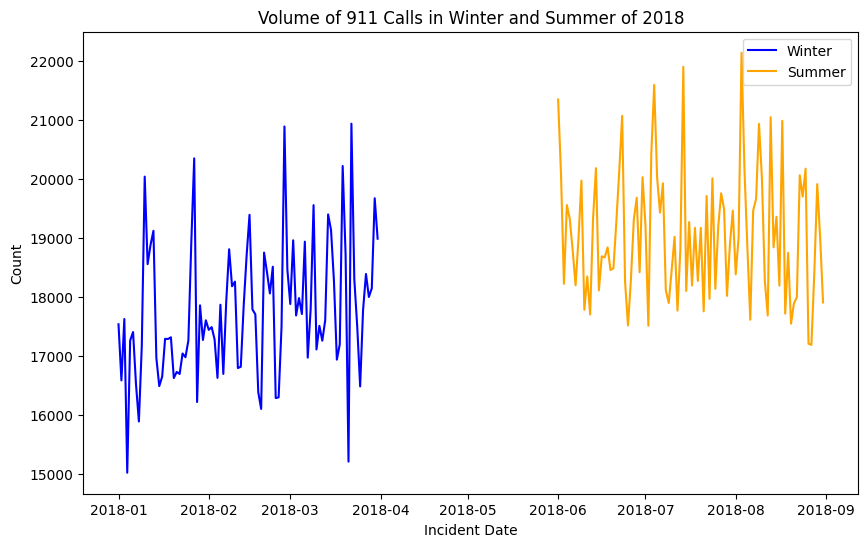

In [26]:
#analyzing the volume of 911 calls in NYC winter and summer 2018
#winter
#connect to postgres and query
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
with conn, conn.cursor() as curs:
    curs.execute("SELECT count(typ_desc) AS count_column, incident_date FROM schema_1.table_1 WHERE incident_date BETWEEN '2018-01-01' AND '2018-03-31' GROUP BY incident_date")
    # turn result into an integer
    df_winter = DataFrame(curs.fetchall(), columns=['count_column_winter', 'incident_date'])
    

#summer
#connect to postgres and query
with conn, conn.cursor() as curs:
    curs.execute("SELECT COUNT(typ_desc) AS count_column_summer, incident_date FROM schema_1.table_1 WHERE incident_date BETWEEN '2018-06-01' AND '2018-08-31' GROUP BY incident_date")
    df_summer = DataFrame(curs.fetchall(), columns=['count_column_summer', 'incident_date'])

# Calculate rolling average
window_size = 1  # Adjust the window size as desired
df_winter['rolling_average_winter'] = df_winter['count_column_winter'].rolling(window_size, min_periods=1).mean()
df_summer['rolling_average_summer'] = df_summer['count_column_summer'].rolling(window_size, min_periods=1).mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_winter['incident_date'], df_winter['rolling_average_winter'], label='Winter', color="blue")
plt.plot(df_summer['incident_date'], df_summer['rolling_average_summer'], label='Summer', color="orange")
plt.title('Volume of 911 Calls in Winter and Summer of 2018')
plt.xlabel('Incident Date')
plt.ylabel('Count')
plt.legend()
plt.show()

